In [75]:
import nsaba.nsaba as na
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from tabulate import tabulate
import numpy as np
import scipy as sp
import random as rn
import csv
import os

import matplotlib as mt
import matplotlib.pyplot as plt
mt.style.use('ggplot')
%matplotlib inline

In [2]:
dd = '../../data_dir'
na.Nsaba.aba_load(dd)
na.Nsaba.ns_load(dd)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.



In [3]:
na.Nsaba.ns_load_id_dict()

This may take a minute or two ...


In [4]:
para = na.Nsaba()
para.load_ge_pickle('Nsaba_ABA_ge.pkl', dd)

This may take a minute or two ...
'ge' dictionary successfully loaded


In [5]:
feat_df = para.get_ns_struct("features_df")

# Term Activation

In [6]:
terms = ['reward', 'attention', 'memory', 'motor']
dfs = []
for term in terms:
    _, df = para._term_to_coords(term, -1)
    dfs.append(df)

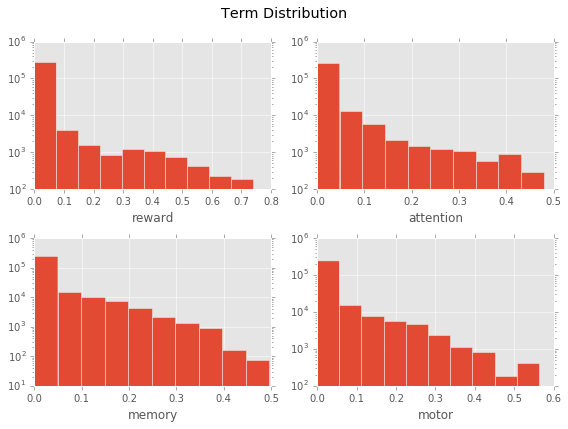

In [7]:
plt.suptitle("Term Distribution", fontsize='x-large');
for term, sb, df in zip(terms, range(221,225), dfs):
    plt.subplot(sb)
    df[term].hist(bins=10, figsize=(8,6));
    plt.yscale('log');
    plt.xlabel(term);

plt.tight_layout()
plt.subplots_adjust(top=.9)

In [51]:
X = df.loc[:, 'x':'z'].as_matrix()
X.shape

(280228, 3)

In [34]:
# Validation Helpers

def plot_vc(pars, train_scores, valid_scores, score, par_name, subplot, term):
    plt.subplot(subplot)
    plt.title(term)
    plt.plot(pars, np.mean(train_scores,1), label="Train")
    plt.plot(pars, np.mean(valid_scores,1), label="CV")
    plt.legend()
    plt.xlabel(par_name);
    plt.ylabel(score);
    
def print_scores(terms, pars, train_scores_, valid_scores_, par_name, error=True):
    entries = []
    if error:
        headers = ["Term", par_name, "Mean Training Error", "Mean CV Error"]
    else:
        headers = ["Term", par_name, "Mean Training Score", "Mean CV Score"]
    for tscores, vscores, term in zip(train_scores_, valid_scores_, terms):
        if error:
            t_means = -np.mean(train_scores,1)
            v_means = -np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
        else:
            t_means = np.mean(train_scores,1)
            v_means = np.mean(valid_scores,1)
            for par, t_err, v_err in zip(pars, t_means, v_means):
                entries.append([term, par, t_err, v_err]) 
    print tabulate(entries, headers=headers)
    
def save_scores(path, terms, pars, train_scores_, 
                valid_scores_, par_name, score_fn, error=True):
    with open(path, 'wb') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        if error:
            headers = ["Term", par_name, "Mean Training Error", 
                       "Mean CV Error", "Error Function"]
        else:
            headers = ["Term", par_name, "Mean Training Score", 
                       "Mean CV Score", "Score Function"]
        writer.writerow(headers)
        for tscores, vscores, term in zip(train_scores_, valid_scores_, terms):
            if error:
                t_means = -np.mean(train_scores,1)
                v_means = -np.mean(valid_scores,1)
                for par, t_err, v_err in zip(pars, t_means, v_means):
                    writer.writerow([term, par, t_err, v_err, score_fn]) 
            else:
                t_means = np.mean(train_scores,1)
                v_means = np.mean(valid_scores,1)
                for par, t_err, v_err in zip(pars, t_means, v_means):
                     writer.writerow([term, par, t_err, v_err, score_fn]) 

In [29]:
# Checking estimation_csv exists
!ls
epath = "estimation_csv"

EI_Ratios.ipynb        neurosynth_dev         testing_nsaba.ipynb
Estimation.ipynb       nsaba_stats.ipynb
estimation_csv         testing_analysis.ipynb


# Decision Tree

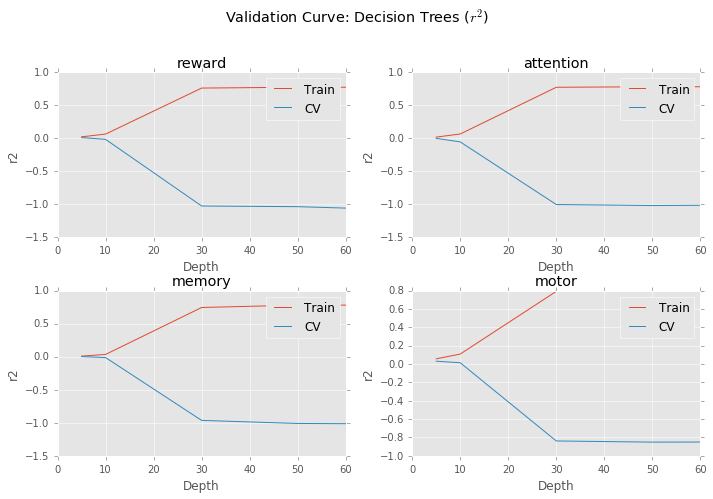

In [74]:
depth=[5,10,30,50,60]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  X, y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, train_scores, valid_scores, 
            score, "Depth", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [41]:
# Printing and saving scores
print_scores(terms, depth, train_scores_, valid_scores_, "Max Depth", error=False)
save_scores(os.path.join(epath, "DT_r2.csv"), terms, depth, 
            train_scores_, valid_scores_, "Max Depth", score_fn=score, error=False)


Term         Max Depth    Mean Training Score    Mean CV Score
---------  -----------  ---------------------  ---------------
reward               5              0.0562237        0.0306199
reward              10              0.108418         0.0139191
reward              30              0.791385        -0.838386
reward              50              0.796681        -0.850953
reward              60              0.796681        -0.850009
attention            5              0.0562237        0.0306199
attention           10              0.108418         0.0139191
attention           30              0.791385        -0.838386
attention           50              0.796681        -0.850953
attention           60              0.796681        -0.850009
memory               5              0.0562237        0.0306199
memory              10              0.108418         0.0139191
memory              30              0.791385        -0.838386
memory              50              0.796681        -0.850953


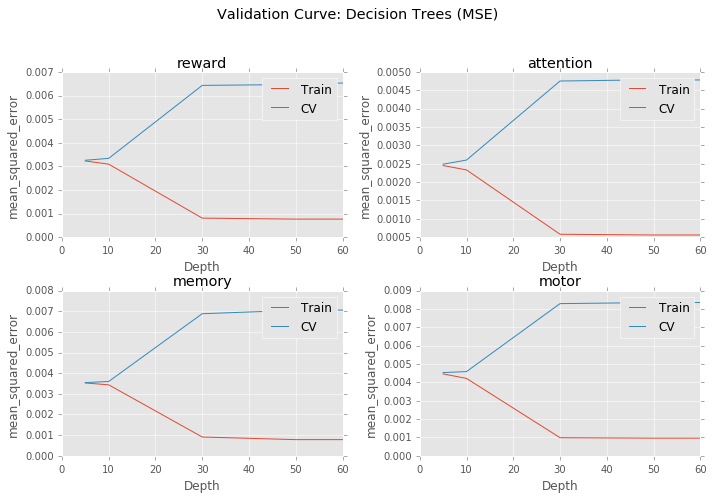

In [73]:
score = 'mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Decision Trees (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(),
                                                  X, y, "max_depth", depth, 
                                                  scoring=score, n_jobs=4, cv=5)
    plot_vc(depth, -train_scores, -valid_scores, 
            score, "Depth", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [43]:
# Printing and saving scores
print_scores(terms, depth, train_scores_, valid_scores_, "Max Depth", error=True)
save_scores(os.path.join(epath, "DT_mse.csv"), terms, depth, 
            train_scores_, valid_scores_, "Max Depth", score_fn=score, error=True)


Term         Max Depth    Mean Training Error    Mean CV Error
---------  -----------  ---------------------  ---------------
reward               5            0.00446175        0.00453347
reward              10            0.00421476        0.00458738
reward              30            0.000986449       0.00829025
reward              50            0.000961601       0.00834769
reward              60            0.000961601       0.00833412
attention            5            0.00446175        0.00453347
attention           10            0.00421476        0.00458738
attention           30            0.000986449       0.00829025
attention           50            0.000961601       0.00834769
attention           60            0.000961601       0.00833412
memory               5            0.00446175        0.00453347
memory              10            0.00421476        0.00458738
memory              30            0.000986449       0.00829025
memory              50            0.000961601       0.0

# Random Forests

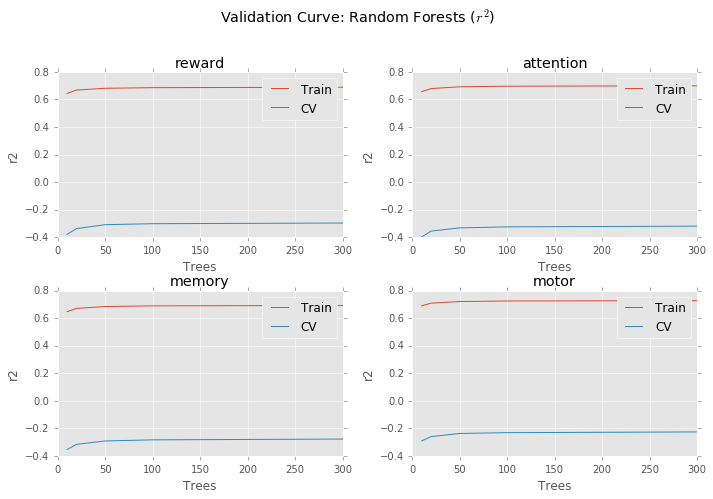

In [62]:
trees=[10,20,50,100,300]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, train_scores, valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [63]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "RF_r2.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10               0.689329        -0.292162
reward          20               0.708855        -0.260378
reward          50               0.720403        -0.237664
reward         100               0.724388        -0.2319
reward         300               0.726948        -0.226591
attention       10               0.689329        -0.292162
attention       20               0.708855        -0.260378
attention       50               0.720403        -0.237664
attention      100               0.724388        -0.2319
attention      300               0.726948        -0.226591
memory          10               0.689329        -0.292162
memory          20               0.708855        -0.260378
memory          50               0.720403        -0.237664
memory         100               0.724388        -0.2319
memory         300               0.726948        -0.226591
mot

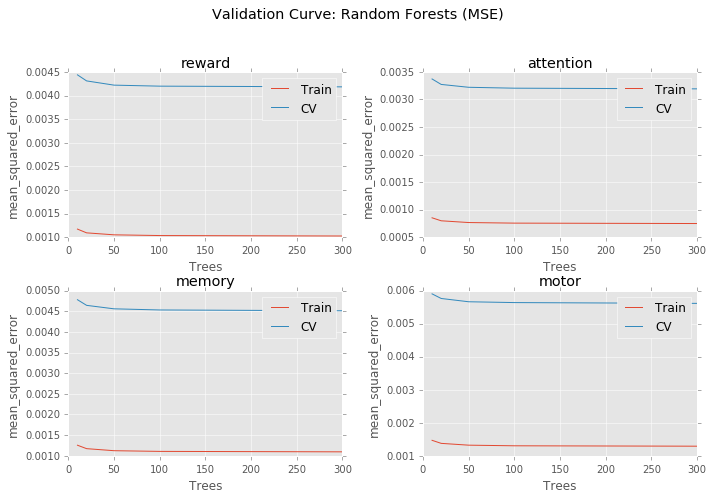

In [66]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Random Forests (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(RandomForestRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(trees, -train_scores, -valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [67]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees")
save_scores(os.path.join(epath, "RF_mse.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score)

Term         Trees    Mean Training Error    Mean CV Error
---------  -------  ---------------------  ---------------
reward          10             0.00146853       0.00590062
reward          20             0.00137638       0.00576116
reward          50             0.0013218        0.00566199
reward         100             0.00130296       0.00563709
reward         300             0.00129084       0.0056129
attention       10             0.00146853       0.00590062
attention       20             0.00137638       0.00576116
attention       50             0.0013218        0.00566199
attention      100             0.00130296       0.00563709
attention      300             0.00129084       0.0056129
memory          10             0.00146853       0.00590062
memory          20             0.00137638       0.00576116
memory          50             0.0013218        0.00566199
memory         100             0.00130296       0.00563709
memory         300             0.00129084       0.0056129


## KNN

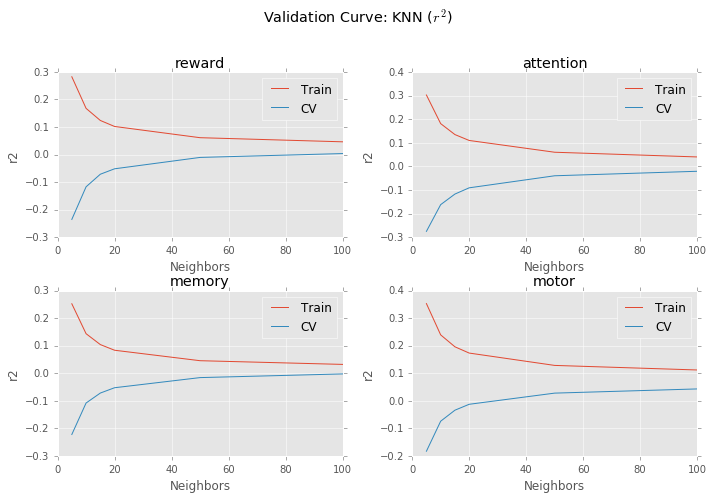

In [68]:
score = 'r2'
neighbors = [5,10,15,20,50,100]

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              X, y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, train_scores, valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [69]:
# Printing and saving scores
print_scores(terms, neighbors, train_scores_, valid_scores_, "Neighbors", error=False)
save_scores(os.path.join(epath, "KNN_r2.csv"), terms, neighbors, 
            train_scores_, valid_scores_, "Neighbors", score_fn=score, error=False)

Term         Neighbors    Mean Training Score    Mean CV Score
---------  -----------  ---------------------  ---------------
reward               5               0.352733       -0.18339
reward              10               0.23916        -0.0743589
reward              15               0.195887       -0.0343755
reward              20               0.17311        -0.0129299
reward              50               0.128265        0.0276267
reward             100               0.111709        0.0428484
attention            5               0.352733       -0.18339
attention           10               0.23916        -0.0743589
attention           15               0.195887       -0.0343755
attention           20               0.17311        -0.0129299
attention           50               0.128265        0.0276267
attention          100               0.111709        0.0428484
memory               5               0.352733       -0.18339
memory              10               0.23916        -0.074358

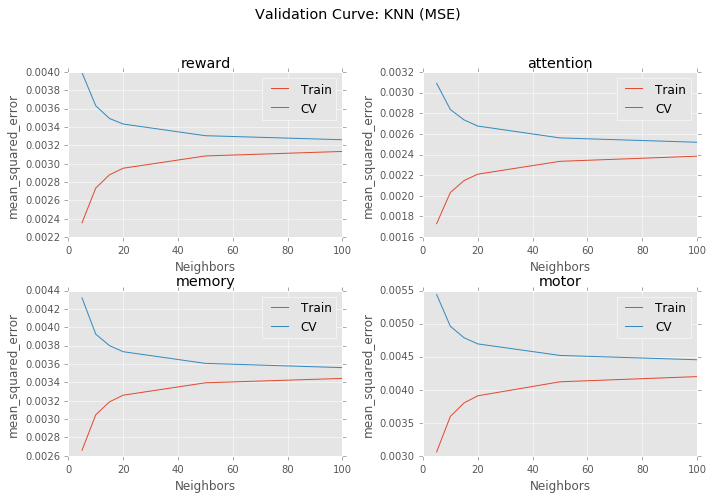

In [82]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: KNN (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(KNeighborsRegressor(),
                                              X, y, "n_neighbors", neighbors, 
                                              scoring=score, n_jobs=4, cv=5)
    plot_vc(neighbors, -train_scores, -valid_scores, 
            score, "Neighbors", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [72]:
# Printing and saving scores
print_scores(terms, neighbors, train_scores_, valid_scores_, "Neighbors")
save_scores(os.path.join(epath, "KNN_mse.csv"), terms, neighbors, 
            train_scores_, valid_scores_, "Neighbors", score_fn=score)

Term         Neighbors    Mean Training Error    Mean CV Error
---------  -----------  ---------------------  ---------------
reward               5             0.00305894       0.00544001
reward              10             0.0035957        0.00496011
reward              15             0.00380028       0.00478597
reward              20             0.00390792       0.00469338
reward              50             0.00412          0.00451869
reward             100             0.00419841       0.00445334
attention            5             0.00305894       0.00544001
attention           10             0.0035957        0.00496011
attention           15             0.00380028       0.00478597
attention           20             0.00390792       0.00469338
attention           50             0.00412          0.00451869
attention          100             0.00419841       0.00445334
memory               5             0.00305894       0.00544001
memory              10             0.0035957        0.0

# Gradient Boosting

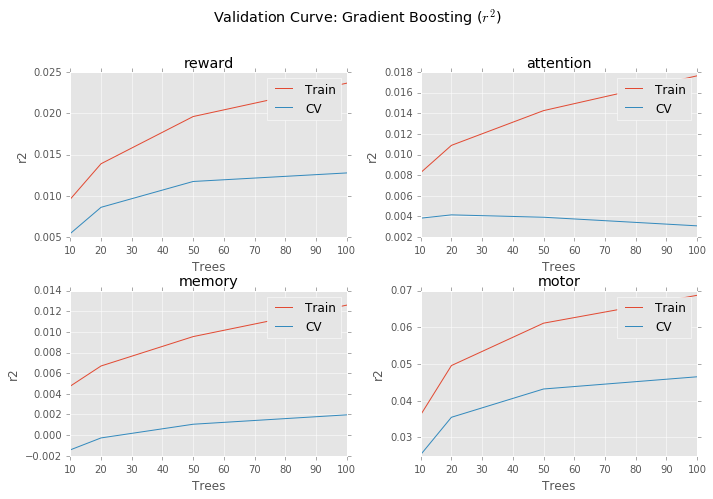

In [77]:
trees=[10,20,50,100]
score = 'r2'
train_scores_ = []
valid_scores_ = []

plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Gradient Boosting ($r^{2}$)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=4)
    plot_vc(trees, train_scores, valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [78]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "GB_r2.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10              0.036165         0.0253176
reward          20              0.0495794        0.0354916
reward          50              0.0611227        0.0431968
reward         100              0.0687149        0.0465199
attention       10              0.036165         0.0253176
attention       20              0.0495794        0.0354916
attention       50              0.0611227        0.0431968
attention      100              0.0687149        0.0465199
memory          10              0.036165         0.0253176
memory          20              0.0495794        0.0354916
memory          50              0.0611227        0.0431968
memory         100              0.0687149        0.0465199
motor           10              0.036165         0.0253176
motor           20              0.0495794        0.0354916
motor           50              0.0611227        0.04319

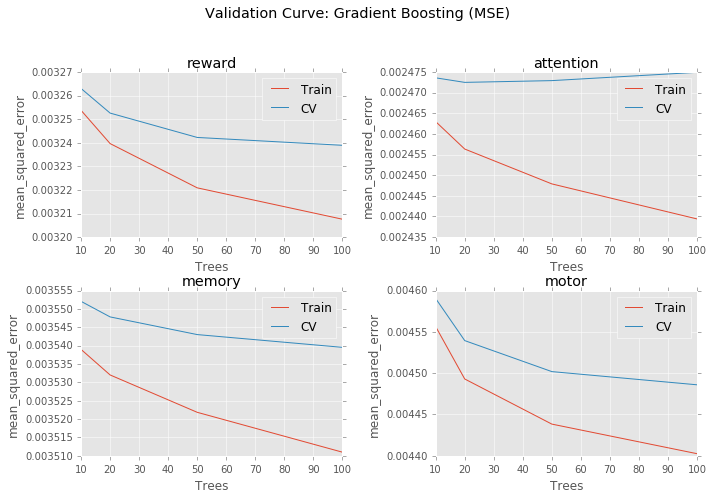

In [80]:
score='mean_squared_error'
train_scores_ = []
valid_scores_ = []
plt.figure(figsize=(10,7))
plt.suptitle("Validation Curve: Gradient Boosting (MSE)", fontsize='x-large')
for term, sb, df in zip(terms, range(221,225), dfs):
    X = df.loc[:, 'x':'z'].as_matrix()
    y = df.loc[:, term].as_matrix()
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(),
                                              X, y, "n_estimators", trees, 
                                              scoring=score, n_jobs=4, cv=4)
    plot_vc(trees, -train_scores, -valid_scores, 
            score, "Trees", sb, term)
    
    train_scores_.append(train_scores)
    valid_scores_.append(valid_scores)

plt.tight_layout()
plt.subplots_adjust(top=.85)

In [81]:
# Printing and saving scores
print_scores(terms, trees, train_scores_, valid_scores_, "Trees", error=False)
save_scores(os.path.join(epath, "GB_mse.csv"), terms, trees, 
            train_scores_, valid_scores_, "Trees", score_fn=score, error=False)

Term         Trees    Mean Training Score    Mean CV Score
---------  -------  ---------------------  ---------------
reward          10            -0.00455639      -0.0045904
reward          20            -0.00449301      -0.00453946
reward          50            -0.00443838      -0.00450193
reward         100            -0.00440256      -0.00448596
attention       10            -0.00455639      -0.0045904
attention       20            -0.00449301      -0.00453946
attention       50            -0.00443838      -0.00450193
attention      100            -0.00440256      -0.00448596
memory          10            -0.00455639      -0.0045904
memory          20            -0.00449301      -0.00453946
memory          50            -0.00443838      -0.00450193
memory         100            -0.00440256      -0.00448596
motor           10            -0.00455639      -0.0045904
motor           20            -0.00449301      -0.00453946
motor           50            -0.00443838      -0.00450193
m